In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import time
from sklearn import metrics
import random
import warnings
warnings.filterwarnings('ignore')
!pip install dtw
from dtw import dtw
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=8c053c301ff542aac4b5c7ee35394c8c7edb00fa17bddc7179deb234ac2bbe93
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw


# **MFCC Extraction**

\begin{align} start_{frame} = \big\lfloor start_{time} \times samplingrate \big\rfloor \end{align}

\begin{align} end_{frame} = \big\lfloor end_{time} \times samplingrate \big\rfloor + 1 \end{align}

mfcc shape 39, x

In [ ]:
def padd_z(y):
    z_rate = 19203 - y.shape[0]
    return np.concatenate([np.zeros((int(z_rate / 2))), y, np.zeros((int(z_rate / 2)))]) if z_rate % 2 == 0 else np.concatenate([np.zeros((int(z_rate / 2) + 1)), y, np.zeros((int(z_rate / 2)))])

def mfcc_lab(path_without_ending, target_list):
    if os.path.isfile(path_without_ending + '.wav') == False or os.path.isfile(path_without_ending + '.txt') == False:
        return
    signal, sr = librosa.load(path_without_ending + '.wav')
    with open(path_without_ending + '.txt') as f:
            for line in f:
                if(line == ''): continue
                gr = ''.join(line).strip().split('\t')

                if len(gr) < 3: continue
                if gr[2] not in ['trai', 'phai', 'len', 'xuong']:   continue


                start_frame = int(float(gr[0]) * sr)
                end_frame = int(float(gr[1]) * sr) + 1
                lab = gr[2]
                # trích chọn đặc trưng trên thang mel với các thông số mặc định sampling rate = 22050, window hann, frame_size = 2048, hop_size = 512 (SFT matrix n_frame x window_length)
                # Dựa vào biến đổi Fast Fourier Transform trên từng frame
                # trích chọn 13 đặc trưng MFCC từ Discrete Cosine Transform với các bộ lọc tam giác nối chân nhau từ spg: ma trận sau khi short time fourier transform trên segment.
                # đặc trưng thứ 13 là trung bình năng lượng của 12 đặc trưng
                mfccs = librosa.feature.mfcc(y=signal[start_frame:end_frame], n_mfcc=13, sr=sr)
                # CMVN
                mfccs = mfccs - np.mean(mfccs, axis=1).reshape((-1, 1))
                # trích chọn 13 đặc trưng tiếp theo chính là đạo hàm của 12 đặc trưng mfccs cộng thêm 1 đặc trưng là trung bình năng lượng của 12 đặc trưng đó
                delta_mfccs = librosa.feature.delta(mfccs, order=1)
                
                # tương tự nhưng là đạo hàm của 12 delta_mfccs và 1 trung bình năng lượng của tầng này
                delta2_mfccs = librosa.feature.delta(mfccs, order=2)
                mfccs_39 = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
                target_list.append([mfccs_39, lab])

In [ ]:
# read data without Silence label
def read_data_from_drive(data_fill):
    path = '/content/drive/My Drive/SpeechData/'
    for fnum in range(1, 11):
        for i in range(1, 101):
            mfcc_lab(path + str(fnum) + '/c' + str(i), data_fill)

In [ ]:
# Segment and label list of list
# element: [ Signal, label]
seg_lab = []
read_data_from_drive(seg_lab)

In [ ]:
len(seg_lab)

4811

# **Dynamic Time Wrapping**

In [ ]:
def save_practical_sample(train_x, train_y):
    cm = '/content/drive/My Drive/SpeechData/align_sample/'
    for i in range(len(train_x)):
        np.savetxt(cm + train_y[i] + '/smp_' + str(i) + '.txt', train_x[i])

In [ ]:
def alignment_validation(train_x, train_y, test_x, test_y): 
    predict = ['' for x in range(len(test_y))]
    rank_train = np.zeros((len(train_y)))
    for i in range(len(test_x)):
        dist_min = np.inf
        min_idx = -1
        for j in range(len(train_y)):
            dist = dtw(test_x[i], train_x[j], dist=lambda test, train: np.linalg.norm(test - train, ord=1))[0]
            if dist_min > dist: 
                dist_min = dist
                min_idx = j
                predict[i] = train_y[j]
        if predict[i] == test_y[i]:
            rank_train[min_idx] += 1
        else:
            rank_train[min_idx] -= 1.5
    return predict, rank_train

def prepare_datasets(dataset, rate_test=0.25):
    random.shuffle(dataset)
    N = int(len(dataset) * (1 - rate_test))
    train_x = [dataset[i][0].T for i in range(N)]
    train_y = [dataset[i][1] for i in range(N)]
    test_x =  [dataset[i][0].T for i in range(N, len(dataset))]
    test_y =  [dataset[i][1] for i in range(N, len(dataset))]
    return train_x, train_y, test_x, test_y

In [ ]:
def predict(samp, train_set_x, train_set_y):
    threehold = 200 # for none class
    dist_min = math.inf
    res = 'none'
    for j in range(len(train_set_y)):
        dist = dtw(samp, train_set_x[j], dist=lambda test, train: np.linalg.norm(test - train, ord=1))[0]
        print(j, dist)
        if dist_min > dist: 
            dist_min = dist
            res = train_set_y[j]
    print('well define: ', dist_min)
    return res

In [ ]:
train_x, train_y, test_x, test_y = prepare_datasets(seg_lab)
# train_x = best_train
predicted, rank_train = alignment_validation(train_x, train_y, test_x, test_y)
expected = test_y

Classification report: 

              precision    recall  f1-score   support

         len       1.00      0.99      1.00       310
        phai       0.98      0.97      0.97       278
        trai       0.97      0.98      0.98       304
       xuong       1.00      0.99      1.00       311

    accuracy                           0.99      1203
   macro avg       0.99      0.99      0.99      1203
weighted avg       0.99      0.99      0.99      1203


Accuracy classification score: 98.59%
Precision classification score: 98.60%


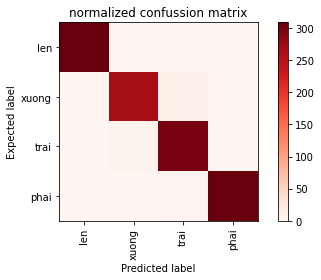

In [ ]:
print("Classification report: \n\n%s\n" % (metrics.classification_report(expected, predicted)))
mat = metrics.confusion_matrix(expected, predicted)
# len, xuong, trai, phai
label_names = list(set(expected))
label_names = [x for x in label_names]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='Reds')
plt.title('normalized confussion matrix')
plt.colorbar()
plt.ylabel('Expected label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=90)
plt.yticks(tick_marks, label_names)
plt.tight_layout()

# accuracy của từng từ đơn
accuracy = metrics.accuracy_score(expected, predicted)
print('Accuracy classification score: {0:.2f}%'.format(100*accuracy))
precision = metrics.precision_score(expected, predicted, average='weighted')
print('Precision classification score: {0:.2f}%'.format(100*precision))

In [ ]:
best_train = []
train_best_y = []
# best of len
def choose_n_best(sub_set, rank_train, n = 15):
    n_best = []
    ss, rk = sub_set.copy(), rank_train.copy()
    for nb in range(n):
        max_idx, max_rk = -1, -np.inf
        for j in range(len(rk)):
            if max_rk < rk[j]:
                max_rk, max_idx = rk[j], j
        n_best.append(ss[max_idx])
        rk = [rk[i] for i in range(len(rk)) if i != max_idx]
        ss = [ss[i] for i in range(len(ss)) if i != max_idx]
    return n_best

for lab in ['len', 'xuong', 'trai', 'phai']:
    best_train.extend(choose_n_best([train_x[i] for i in range(len(train_x)) if train_y[i] == lab], [rank_train[i] for i in range(len(rank_train)) if train_y[i] == lab]))
    train_best_y.extend([lab] * 15)

save_practical_sample(best_train, train_best_y)

In [ ]:
prd = alignment_validation(best_train, train_best_y, test_x, test_y)[0]

In [ ]:
save_practical_sample(best_train, train_best_y)

In [ ]:
print(metrics.classification_report(prd, test_y))

              precision    recall  f1-score   support

         len       1.00      0.95      0.97       324
        phai       0.79      0.89      0.84       247
        trai       0.90      0.85      0.88       321
       xuong       0.98      0.98      0.98       311

    accuracy                           0.92      1203
   macro avg       0.92      0.92      0.92      1203
weighted avg       0.93      0.92      0.92      1203



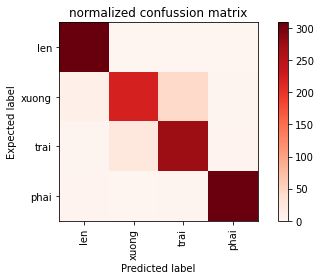

In [ ]:
mat = metrics.confusion_matrix(test_y, prd)
# len, xuong, trai, phai
label_names = list(set(expected))
label_names = [x for x in label_names]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='Reds')
plt.title('normalized confussion matrix')
plt.colorbar()
plt.ylabel('Expected label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=90)
plt.yticks(tick_marks, label_names)
plt.tight_layout()